## 1. Подготовка данных и оценка пригодности датасета

Сначала необходимо оценить, насколько набор данных подходит для решения задачи классификации:
1. Определить целевой класс (метку) — что предсказывает датасет
2. Оценить сбалансированность классов


In [ ]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        pass  # Используем дефолтный стиль
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Библиотеки успешно импортированы!")


Библиотеки успешно импортированы!


In [2]:
# Загрузка датасета
df = pd.read_csv('earthquake_data_tsunami.csv')

print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
df.head()


Размер датасета: (782, 13)

Первые 5 строк:


,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


In [3]:
# Добавляем атрибут интенсивности (как в Lab2)
df['intensity'] = df['magnitude'] / (df['depth'] + 1)

print("Атрибут 'intensity' добавлен!")
print(f"Размер датасета: {df.shape}")


Атрибут 'intensity' добавлен!
Размер датасета: (782, 14)


### 1.1. Определение целевого класса

В данном датасете целевым классом является атрибут **`tsunami`**, который указывает, произошло ли цунами после землетрясения:
- **0** - цунами не произошло
- **1** - цунами произошло

Это бинарная задача классификации.


АНАЛИЗ ЦЕЛЕВОГО КЛАССА 'tsunami'

Уникальные значения: [1 0]

Тип данных: int64

Распределение классов:
Класс 0 (без цунами): 478 (61.13%)
Класс 1 (с цунами): 304 (38.87%)


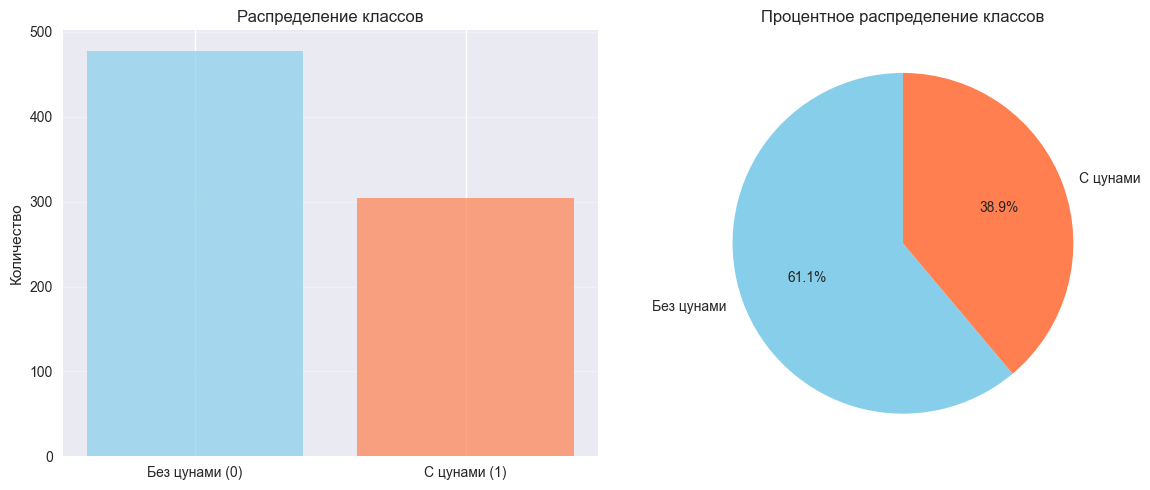


Соотношение классов (min/max): 0.636
⚠ Классы умеренно несбалансированы


In [5]:
# Анализ целевого класса
print("АНАЛИЗ ЦЕЛЕВОГО КЛАССА 'tsunami'\n")

# Проверяем уникальные значения
print("Уникальные значения:", df['tsunami'].unique())
print("\nТип данных:", df['tsunami'].dtype)

# Подсчет количества по классам
class_counts = df['tsunami'].value_counts().sort_index()
class_percentages = df['tsunami'].value_counts(normalize=True).sort_index() * 100

print("\nРаспределение классов:")
print(f"Класс 0 (без цунами): {class_counts[0]} ({class_percentages[0]:.2f}%)")
print(f"Класс 1 (с цунами): {class_counts[1]} ({class_percentages[1]:.2f}%)")

# Визуализация распределения классов
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Столбчатая диаграмма
axes[0].bar(['Без цунами (0)', 'С цунами (1)'], class_counts.values, 
            color=['skyblue', 'coral'], alpha=0.7)
axes[0].set_ylabel('Количество')
axes[0].set_title('Распределение классов')
axes[0].grid(True, alpha=0.3, axis='y')

# Круговая диаграмма
axes[1].pie(class_counts.values, labels=['Без цунами', 'С цунами'], 
            autopct='%1.1f%%', colors=['skyblue', 'coral'], startangle=90)
axes[1].set_title('Процентное распределение классов')

plt.tight_layout()
plt.show()

# Оценка сбалансированности
ratio = min(class_counts) / max(class_counts)
print(f"\nСоотношение классов (min/max): {ratio:.3f}")

if ratio > 0.8:
    print("✓ Классы хорошо сбалансированы")
elif ratio > 0.5:
    print("⚠ Классы умеренно несбалансированы")
else:
    print("✗ Классы сильно несбалансированы")


### 1.2. Выводы о пригодности датасета

**Целевой класс:** `tsunami` (бинарная классификация)

**Сбалансированность классов:** 
- Датасет содержит данные о землетрясениях с цунами и без
- Необходимо проверить соотношение классов для оценки сбалансированности


## 2. Подготовка данных для классификации

Перед применением алгоритмов классификации необходимо:
1. Выбрать признаки (features)
2. Разделить данные на обучающую и тестовую выборки
3. Нормализовать данные (для kNN)


In [6]:
# Выбор признаков для классификации
# Исключаем неинформативные признаки и целевой класс
features_to_exclude = ['tsunami', 'Year', 'Month']  # Year и Month могут быть нерелевантны

# Выбираем числовые признаки
feature_columns = [col for col in df.columns 
                   if col not in features_to_exclude and df[col].dtype in ['int64', 'float64']]

print("Выбранные признаки для классификации:")
print(feature_columns)
print(f"\nКоличество признаков: {len(feature_columns)}")

# Создаем матрицу признаков и вектор меток
X = df[feature_columns].copy()
y = df['tsunami'].copy()

print(f"\nРазмер матрицы признаков X: {X.shape}")
print(f"Размер вектора меток y: {y.shape}")

# Проверяем на пропущенные значения
print(f"\nПропущенные значения в X: {X.isnull().sum().sum()}")
print(f"Пропущенные значения в y: {y.isnull().sum()}")


Выбранные признаки для классификации:
['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude', 'intensity']

Количество признаков: 11

Размер матрицы признаков X: (782, 11)
Размер вектора меток y: (782,)

Пропущенные значения в X: 0
Пропущенные значения в y: 0


In [7]:
# Разделение данных на обучающую и тестовую выборки
# Используем 70% для обучения, 30% для тестирования
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Разделение данных выполнено:")
print(f"Обучающая выборка: {X_train.shape[0]} образцов ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Тестовая выборка: {X_test.shape[0]} образцов ({X_test.shape[0]/len(X)*100:.1f}%)")

print("\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts().sort_index())
print("\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts().sort_index())


Разделение данных выполнено:
Обучающая выборка: 547 образцов (69.9%)
Тестовая выборка: 235 образцов (30.1%)

Распределение классов в обучающей выборке:
tsunami
0    334
1    213
Name: count, dtype: int64

Распределение классов в тестовой выборке:
tsunami
0    144
1     91
Name: count, dtype: int64


In [25]:
# Нормализация данных для kNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Преобразуем обратно в DataFrame для удобства
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)

print("Данные нормализованы")
print("\nСтатистика нормализованных данных (обучающая выборка):")
print(X_train_scaled.describe().round(3))


Данные нормализованы

Статистика нормализованных данных (обучающая выборка):
       magnitude      cdi      mmi      sig      nst     dmin      gap  \
count    547.000  547.000  547.000  547.000  547.000  547.000  547.000   
mean      -0.000   -0.000    0.000   -0.000    0.000    0.000   -0.000   
std        1.001    1.001    1.001    1.001    1.001    1.001    1.001   
min       -0.963   -1.347   -3.412   -0.676   -0.918   -0.578   -1.015   
25%       -0.748   -1.347   -0.673   -0.553   -0.918   -0.578   -0.437   
50%       -0.317    0.213    0.011   -0.359   -0.358   -0.578   -0.204   
75%        0.330    0.838    0.696    0.126    0.871    0.206    0.164   
max        4.641    1.462    2.065    6.152    2.845    7.431    8.345   

         depth  latitude  longitude  intensity  
count  547.000   547.000    547.000    547.000  
mean     0.000     0.000      0.000      0.000  
std      1.001     1.001      1.001      1.001  
min     -0.513    -2.425     -1.992     -1.282  
25%     -0.

## 3. Применение алгоритмов классификации

### 3.1. Метод k-ближайших соседей (kNN)


ПОДБОР ОПТИМАЛЬНОГО ПАРАМЕТРА k ДЛЯ kNN

k= 1: Accuracy = 0.7830
k= 2: Accuracy = 0.7787
k= 3: Accuracy = 0.8085
k= 4: Accuracy = 0.7872
k= 5: Accuracy = 0.7957
k= 6: Accuracy = 0.7787
k= 7: Accuracy = 0.8128
k= 8: Accuracy = 0.7787
k= 9: Accuracy = 0.8128
k=10: Accuracy = 0.7830
k=11: Accuracy = 0.8000
k=12: Accuracy = 0.7872
k=13: Accuracy = 0.7957
k=14: Accuracy = 0.8085
k=15: Accuracy = 0.8043
k=16: Accuracy = 0.8000
k=17: Accuracy = 0.8128
k=18: Accuracy = 0.8085
k=19: Accuracy = 0.8128
k=20: Accuracy = 0.8043

Оптимальное k: 7 (Accuracy = 0.8128)


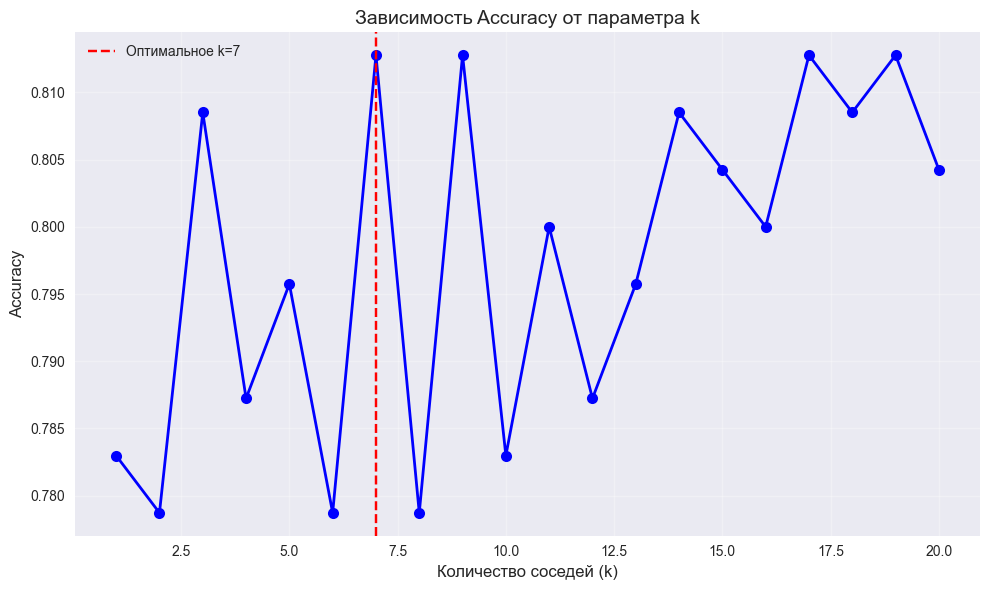

In [9]:
# Подбор оптимального k для kNN
print("ПОДБОР ОПТИМАЛЬНОГО ПАРАМЕТРА k ДЛЯ kNN\n")

k_range = range(1, 21)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    score = knn.score(X_test_scaled, y_test)
    k_scores.append(score)
    print(f"k={k:2d}: Accuracy = {score:.4f}")

# Находим оптимальное k
optimal_k = k_range[np.argmax(k_scores)]
print(f"\nОптимальное k: {optimal_k} (Accuracy = {max(k_scores):.4f})")

# Визуализация зависимости accuracy от k
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Оптимальное k={optimal_k}')
plt.xlabel('Количество соседей (k)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Зависимость Accuracy от параметра k', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
# Обучение kNN с оптимальным k
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train_scaled, y_train)

# Предсказания
y_pred_knn = knn.predict(X_test_scaled)
y_pred_proba_knn = knn.predict_proba(X_test_scaled)[:, 1]

print(f"Использовано k = {optimal_k} соседей")


Использовано k = 7 соседей


### 3.2. Дерево решений (Decision Tree)


ПОДБОР ОПТИМАЛЬНОЙ ГЛУБИНЫ ДЕРЕВА

max_depth= 1: Accuracy = 0.8170
max_depth= 2: Accuracy = 0.8085
max_depth= 3: Accuracy = 0.8511
max_depth= 4: Accuracy = 0.8723
max_depth= 5: Accuracy = 0.8809
max_depth= 6: Accuracy = 0.8894
max_depth= 7: Accuracy = 0.8894
max_depth= 8: Accuracy = 0.8851
max_depth= 9: Accuracy = 0.8723
max_depth=10: Accuracy = 0.8809
max_depth=11: Accuracy = 0.8766
max_depth=12: Accuracy = 0.8766
max_depth=13: Accuracy = 0.8766
max_depth=14: Accuracy = 0.8766
max_depth=15: Accuracy = 0.8766
max_depth=16: Accuracy = 0.8766
max_depth=17: Accuracy = 0.8766
max_depth=18: Accuracy = 0.8766
max_depth=19: Accuracy = 0.8766
max_depth=20: Accuracy = 0.8766

Оптимальная глубина: 6 (Accuracy = 0.8894)


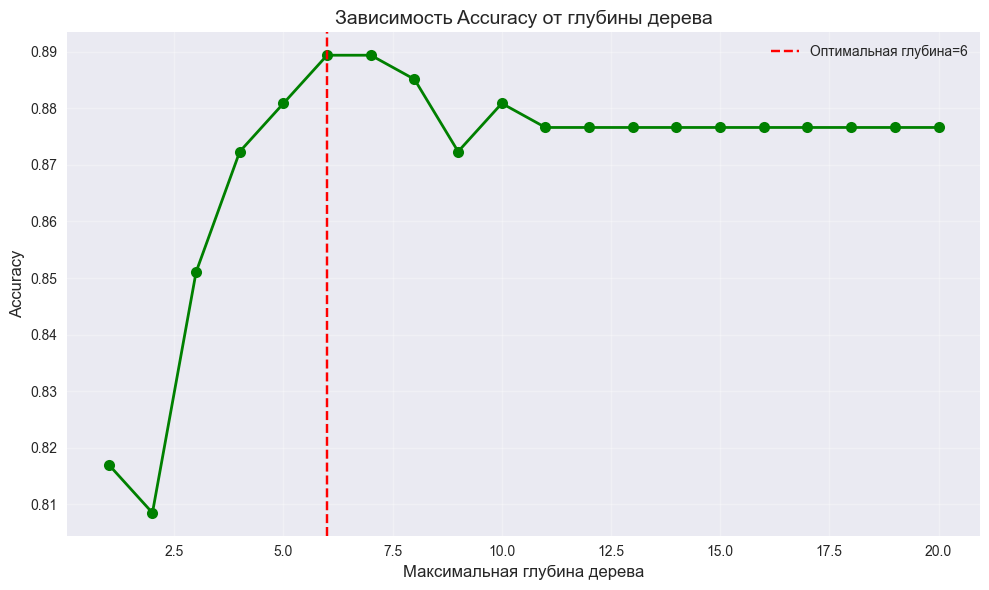

In [16]:
# Подбор оптимальной глубины дерева
print("ПОДБОР ОПТИМАЛЬНОЙ ГЛУБИНЫ ДЕРЕВА\n")

max_depth_range = range(1, 21)
dt_scores = []

for depth in max_depth_range:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    score = dt.score(X_test, y_test)
    dt_scores.append(score)
    print(f"max_depth={depth:2d}: Accuracy = {score:.4f}")

# Находим оптимальную глубину
optimal_depth = max_depth_range[np.argmax(dt_scores)]
print(f"\nОптимальная глубина: {optimal_depth} (Accuracy = {max(dt_scores):.4f})")

# Визуализация зависимости accuracy от глубины
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, dt_scores, 'go-', linewidth=2, markersize=8)
plt.axvline(x=optimal_depth, color='r', linestyle='--', label=f'Оптимальная глубина={optimal_depth}')
plt.xlabel('Максимальная глубина дерева', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Зависимость Accuracy от глубины дерева', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
# Обучение дерева решений с оптимальной глубиной
dt = DecisionTreeClassifier(max_depth=optimal_depth, random_state=42)
dt.fit(X_train, y_train)

# Предсказания
y_pred_dt = dt.predict(X_test)
y_pred_proba_dt = dt.predict_proba(X_test)[:, 1]

print(f"Использована максимальная глубина = {optimal_depth}")


Использована максимальная глубина = 6


## 4. Оценка качества классификации

Сравним результаты обоих алгоритмов с помощью различных метрик:
1. **Accuracy** - общая точность
2. **Precision, Recall, F-measure** - метрики для каждого класса
3. **ROC-кривая и AUC** - оценка качества бинарной классификации


СРАВНЕНИЕ МЕТРИК КАЧЕСТВА КЛАССИФИКАЦИИ

Сводная таблица метрик:
  Метрика    kNN  Дерево решений
 Accuracy 0.8128          0.8894
Precision 0.7374          0.8495
   Recall 0.8022          0.8681
 F1-score 0.7684          0.8587
  ROC-AUC 0.8665          0.8883


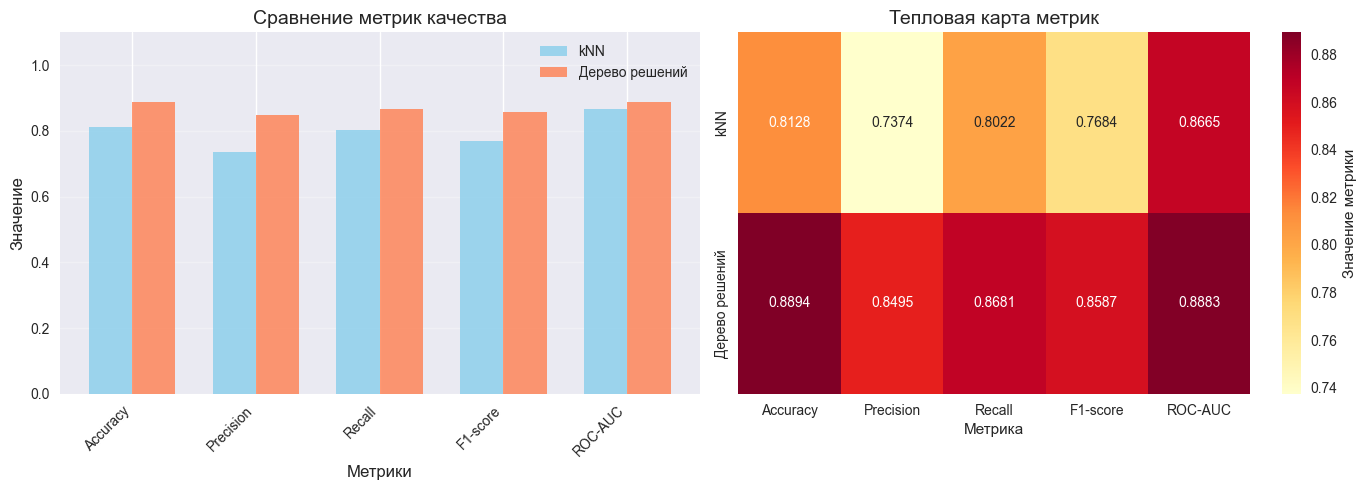

In [30]:
# Вычисление метрик для обоих алгоритмов
print("СРАВНЕНИЕ МЕТРИК КАЧЕСТВА КЛАССИФИКАЦИИ")

# Метрики для kNN
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_pred_proba_knn)

# Метрики для дерева решений
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

# Создаем таблицу сравнения
comparison_df = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'],
    'kNN': [accuracy_knn, precision_knn, recall_knn, f1_knn, roc_auc_knn],
    'Дерево решений': [accuracy_dt, precision_dt, recall_dt, f1_dt, roc_auc_dt]
})

comparison_df['kNN'] = comparison_df['kNN'].round(4)
comparison_df['Дерево решений'] = comparison_df['Дерево решений'].round(4)

print("\nСводная таблица метрик:")
print(comparison_df.to_string(index=False))

# Визуализация сравнения метрик
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Столбчатая диаграмма метрик
x = np.arange(len(comparison_df))
width = 0.35
axes[0].bar(x - width/2, comparison_df['kNN'], width, label='kNN', alpha=0.8, color='skyblue')
axes[0].bar(x + width/2, comparison_df['Дерево решений'], width, label='Дерево решений', alpha=0.8, color='coral')
axes[0].set_xlabel('Метрики', fontsize=12)
axes[0].set_ylabel('Значение', fontsize=12)
axes[0].set_title('Сравнение метрик качества', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Метрика'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.1])

# Тепловая карта метрик
metrics_matrix = comparison_df.set_index('Метрика')[['kNN', 'Дерево решений']].T
sns.heatmap(metrics_matrix, annot=True, fmt='.4f', cmap='YlOrRd', ax=axes[1], 
            cbar_kws={'label': 'Значение метрики'})
axes[1].set_title('Тепловая карта метрик', fontsize=14)
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


In [29]:
# Детальные отчеты по классификации
print("ДЕТАЛЬНЫЙ ОТЧЕТ: kNN")

print(classification_report(y_test, y_pred_knn, target_names=['Без цунами', 'С цунами']))

print("ДЕТАЛЬНЫЙ ОТЧЕТ: Дерево решений")
print(classification_report(y_test, y_pred_dt, target_names=['Без цунами', 'С цунами']))


ДЕТАЛЬНЫЙ ОТЧЕТ: kNN
              precision    recall  f1-score   support

  Без цунами       0.87      0.82      0.84       144
    С цунами       0.74      0.80      0.77        91

    accuracy                           0.81       235
   macro avg       0.80      0.81      0.81       235
weighted avg       0.82      0.81      0.81       235

ДЕТАЛЬНЫЙ ОТЧЕТ: Дерево решений
              precision    recall  f1-score   support

  Без цунами       0.92      0.90      0.91       144
    С цунами       0.85      0.87      0.86        91

    accuracy                           0.89       235
   macro avg       0.88      0.89      0.88       235
weighted avg       0.89      0.89      0.89       235



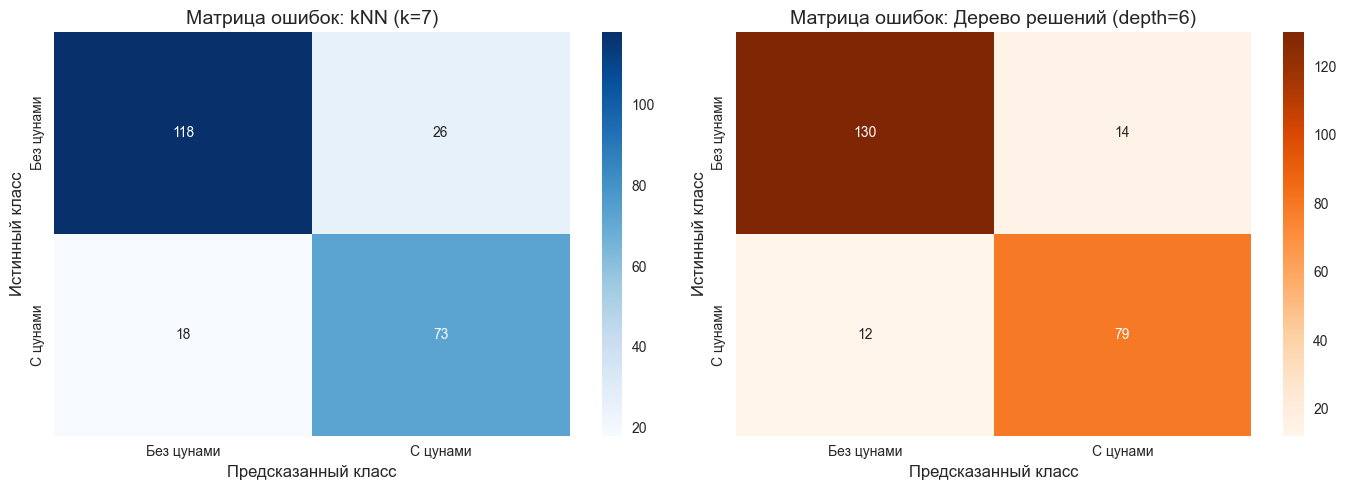

Матрица ошибок для kNN:
                Предсказано
              Без цунами  С цунами
Истина Без цунами     118        26
       С цунами        18        73

Матрица ошибок для дерева решений:
                Предсказано
              Без цунами  С цунами
Истина Без цунами     130        14
       С цунами        12        79


In [21]:
# Матрицы ошибок (Confusion Matrix)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Матрица ошибок для kNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Без цунами', 'С цунами'],
            yticklabels=['Без цунами', 'С цунами'])
axes[0].set_title(f'Матрица ошибок: kNN (k={optimal_k})', fontsize=14)
axes[0].set_ylabel('Истинный класс', fontsize=12)
axes[0].set_xlabel('Предсказанный класс', fontsize=12)

# Матрица ошибок для дерева решений
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Без цунами', 'С цунами'],
            yticklabels=['Без цунами', 'С цунами'])
axes[1].set_title(f'Матрица ошибок: Дерево решений (depth={optimal_depth})', fontsize=14)
axes[1].set_ylabel('Истинный класс', fontsize=12)
axes[1].set_xlabel('Предсказанный класс', fontsize=12)

plt.tight_layout()
plt.show()

# Выводим числовые значения матриц ошибок
print("Матрица ошибок для kNN:")
print("                Предсказано")
print("              Без цунами  С цунами")
print(f"Истина Без цунами    {cm_knn[0,0]:4d}      {cm_knn[0,1]:4d}")
print(f"       С цунами      {cm_knn[1,0]:4d}      {cm_knn[1,1]:4d}")

print("\nМатрица ошибок для дерева решений:")
print("                Предсказано")
print("              Без цунами  С цунами")
print(f"Истина Без цунами    {cm_dt[0,0]:4d}      {cm_dt[0,1]:4d}")
print(f"       С цунами      {cm_dt[1,0]:4d}      {cm_dt[1,1]:4d}")


### 4.1. ROC-кривая и AUC


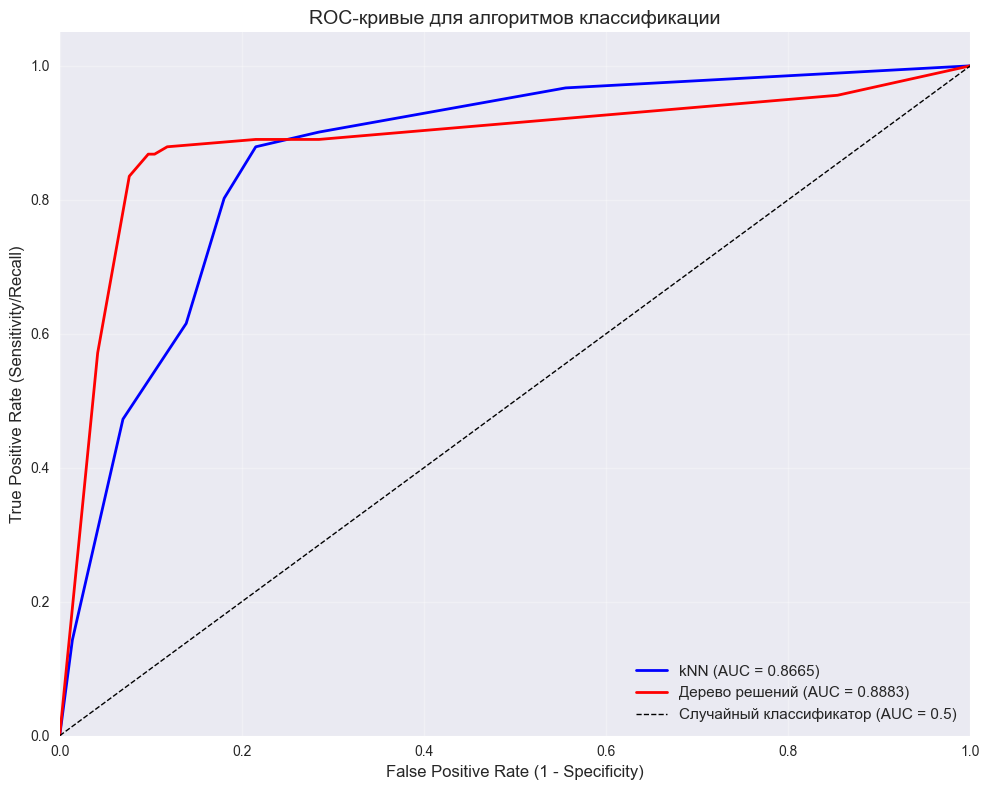

ROC-AUC значения:
kNN: 0.8665
Дерево решений: 0.8883

✓ Дерево решений показывает лучшее значение ROC-AUC (превышение на 0.0218)


In [ ]:
# Построение ROC-кривых
# False Positive Rate — доля ложных срабатываний
# True Positive Rate — доля правильно найденных (Recall)
# thresholds — пороги классификации
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_proba_knn)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt)

# Визуализация ROC-кривых
plt.figure(figsize=(10, 8))
plt.plot(fpr_knn, tpr_knn, linewidth=2, label=f'kNN (AUC = {roc_auc_knn:.4f})', color='blue')
plt.plot(fpr_dt, tpr_dt, linewidth=2, label=f'Дерево решений (AUC = {roc_auc_dt:.4f})', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Случайный классификатор (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12)
plt.title('ROC-кривые для алгоритмов классификации', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("ROC-AUC значения:")
print(f"kNN: {roc_auc_knn:.4f}")
print(f"Дерево решений: {roc_auc_dt:.4f}")

if roc_auc_knn > roc_auc_dt:
    print(f"\n✓ kNN показывает лучшее значение ROC-AUC (превышение на {roc_auc_knn - roc_auc_dt:.4f})")
elif roc_auc_dt > roc_auc_knn:
    print(f"\n✓ Дерево решений показывает лучшее значение ROC-AUC (превышение на {roc_auc_dt - roc_auc_knn:.4f})")
else:
    print("\n✓ Оба алгоритма показывают одинаковое значение ROC-AUC")


## 5. Анализ важности признаков (для дерева решений)


Важность признаков в дереве решений:
  Признак  Важность
     dmin  0.527525
longitude  0.276138
 latitude  0.109809
intensity  0.031603
      nst  0.015210
magnitude  0.014864
      mmi  0.008104
      gap  0.007745
    depth  0.005578
      sig  0.003422
      cdi  0.000000


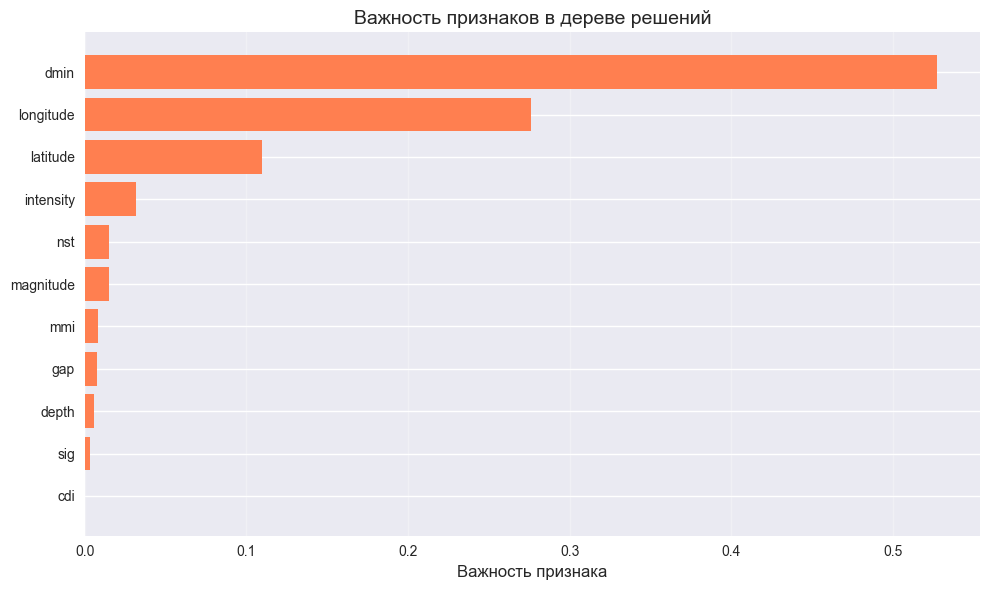

In [23]:
# Важность признаков в дереве решений
feature_importance = pd.DataFrame({
    'Признак': feature_columns,
    'Важность': dt.feature_importances_
}).sort_values('Важность', ascending=False)

print("Важность признаков в дереве решений:")
print(feature_importance.to_string(index=False))

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['Важность'].values, color='coral')
plt.yticks(range(len(feature_importance)), feature_importance['Признак'].values)
plt.xlabel('Важность признака', fontsize=12)
plt.title('Важность признаков в дереве решений', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


## 6. Объяснение полученных результатов

### 6.1. Сравнение алгоритмов

**kNN:**
- **Принцип работы:** Классифицирует объект на основе классов k ближайших к нему объектов в пространстве признаков (по пространственному Пифагору)
- **Преимущества:** Простота реализации, не требует обучения модели (ленивое обучение)
- **Недостатки:** Требует нормализации, медленное предсказание на больших данных

**Дерево решений:**
- **Принцип работы:** Строит иерархическую структуру IF-ов для классификации
- **Преимущества:** Легко интерпретируется, не требует нормализации, может работать с категориальными признаками
- **Недостатки:** Склонность к переобучению, чувствительность к небольшим изменениям данных

### 6.2. Интерпретация метрик

**Accuracy (Точность):**
- Показывает долю правильно классифицированных объектов
- Может быть обманчивой при несбалансированных классах

**Precision (Точность/Прецизионность):**
- Для класса "С цунами": доля объектов, предсказанных как "с цунами", которые действительно имеют цунами
- Высокий Precision означает мало ложных срабатываний

**Recall (Полнота/Чувствительность):**
- Для класса "С цунами": доля объектов с цунами, которые были правильно предсказаны
- Высокий Recall означает, что мы находим большинство случаев с цунами

**F1-score:**
- Гармоническое среднее Precision и Recall
- Балансирует между точностью и полнотой

**ROC-AUC:**
- Площадь под ROC-кривой
- Показывает способность модели различать классы
- Значение от 0 до 1, где 1 - идеальная модель, 0.5 - случайный классификатор


In [31]:
# Создаем итоговую таблицу с интерпретацией результатов
print("ИТОГОВОЕ СРАВНЕНИЕ АЛГОРИТМОВ")

results_summary = pd.DataFrame({
    'Алгоритм': ['kNN', 'Дерево решений'],
    'Accuracy': [f"{accuracy_knn:.4f}", f"{accuracy_dt:.4f}"],
    'Precision': [f"{precision_knn:.4f}", f"{precision_dt:.4f}"],
    'Recall': [f"{recall_knn:.4f}", f"{recall_dt:.4f}"],
    'F1-score': [f"{f1_knn:.4f}", f"{f1_dt:.4f}"],
    'ROC-AUC': [f"{roc_auc_knn:.4f}", f"{roc_auc_dt:.4f}"]
})

print("\nСводная таблица результатов:")
print(results_summary.to_string(index=False))

# Определяем лучший алгоритм по каждой метрике
print("АНАЛИЗ РЕЗУЛЬТАТОВ:")

if accuracy_knn > accuracy_dt:
    print(f"✓ kNN показывает лучшую Accuracy ({accuracy_knn:.4f} vs {accuracy_dt:.4f})")
elif accuracy_dt > accuracy_knn:
    print(f"✓ Дерево решений показывает лучшую Accuracy ({accuracy_dt:.4f} vs {accuracy_knn:.4f})")
else:
    print("✓ Оба алгоритма показывают одинаковую Accuracy")

if precision_knn > precision_dt:
    print(f"✓ kNN показывает лучшую Precision ({precision_knn:.4f} vs {precision_dt:.4f})")
elif precision_dt > precision_knn:
    print(f"✓ Дерево решений показывает лучшую Precision ({precision_dt:.4f} vs {precision_knn:.4f})")
else:
    print("✓ Оба алгоритма показывают одинаковую Precision")

if recall_knn > recall_dt:
    print(f"✓ kNN показывает лучший Recall ({recall_knn:.4f} vs {recall_dt:.4f})")
elif recall_dt > recall_knn:
    print(f"✓ Дерево решений показывает лучший Recall ({recall_dt:.4f} vs {recall_knn:.4f})")
else:
    print("✓ Оба алгоритма показывают одинаковый Recall")

if f1_knn > f1_dt:
    print(f"✓ kNN показывает лучший F1-score ({f1_knn:.4f} vs {f1_dt:.4f})")
elif f1_dt > f1_knn:
    print(f"✓ Дерево решений показывает лучший F1-score ({f1_dt:.4f} vs {f1_knn:.4f})")
else:
    print("✓ Оба алгоритма показывают одинаковый F1-score")

if roc_auc_knn > roc_auc_dt:
    print(f"✓ kNN показывает лучший ROC-AUC ({roc_auc_knn:.4f} vs {roc_auc_dt:.4f})")
elif roc_auc_dt > roc_auc_knn:
    print(f"✓ Дерево решений показывает лучший ROC-AUC ({roc_auc_dt:.4f} vs {roc_auc_knn:.4f})")
else:
    print("✓ Оба алгоритма показывают одинаковый ROC-AUC")


ИТОГОВОЕ СРАВНЕНИЕ АЛГОРИТМОВ

Сводная таблица результатов:
      Алгоритм Accuracy Precision Recall F1-score ROC-AUC
           kNN   0.8128    0.7374 0.8022   0.7684  0.8665
Дерево решений   0.8894    0.8495 0.8681   0.8587  0.8883
АНАЛИЗ РЕЗУЛЬТАТОВ:
✓ Дерево решений показывает лучшую Accuracy (0.8894 vs 0.8128)
✓ Дерево решений показывает лучшую Precision (0.8495 vs 0.7374)
✓ Дерево решений показывает лучший Recall (0.8681 vs 0.8022)
✓ Дерево решений показывает лучший F1-score (0.8587 vs 0.7684)
✓ Дерево решений показывает лучший ROC-AUC (0.8883 vs 0.8665)
